Mounted at /content/drive
Image shape: (224, 224, 3), Label: 2


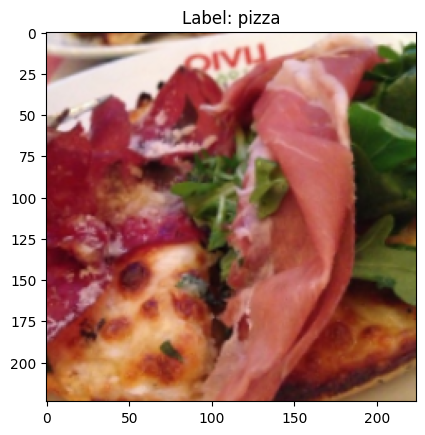

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 876s 12s/step - accuracy: 0.4082 - loss: 1.0974 - val_accuracy: 0.3333 - val_loss: 1.1208
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 501s 7s/step - accuracy: 0.5466 - loss: 0.9653 - val_accuracy: 0.3333 - val_loss: 1.1636
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 509s 7s/step - accuracy: 0.6484 - loss: 0.8464 - val_accuracy: 0.3267 - val_loss: 1.1033
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 557s 7s/step - accuracy: 0.7146 - loss: 0.7652 - val_accuracy: 0.3360 - val_loss: 1.1092
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 507s 7s/step - accuracy: 0.7415 - loss: 0.7051 - val_accuracy: 0.3333 - val_loss: 1.1431
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 556s 7s/step - accuracy: 0.7509 - loss: 0.6377 - val_accuracy: 0.3347 - val_loss: 1.1513
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 502s 7s/step - accuracy: 0.7534 - loss: 0.6172 - val_accuracy: 0.3813 - val_loss: 1.0887
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 514s 7s/step - accura

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB2
import matplotlib.pyplot as plt
from google.colab import drive


drive.mount('/content/drive')

target_classes = ['steak', 'tacos', 'pizza']
data_dir = "/content/drive/MyDrive/food/images"
meta_dir = "/content/drive/MyDrive/food/meta"
train_file = os.path.join(meta_dir, "train.txt")
test_file = os.path.join(meta_dir, "test.txt")

def load_data(file_path):
    images, labels = [], []
    with open(file_path, "r") as f:
        for line in f:
            label, image_name = line.strip().split("/")
            if label in target_classes:
                image_path = os.path.join(data_dir, label, f"{image_name}.jpg")
                if os.path.exists(image_path):
                    images.append(image_path)
                    labels.append(target_classes.index(label))
    return images, labels

train_paths, train_labels = load_data(train_file)
test_paths, test_labels = load_data(test_file)

image_size = (224, 224)
num_classes = len(target_classes)


def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = image / 255.0
    return image, label


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])


def preprocess_image_with_augmentation(image_path, label):
    image, label = preprocess_image(image_path, label)
    image = data_augmentation(image)
    return image, label

# Créer des datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.map(preprocess_image_with_augmentation).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

#(affichage d'exemple)
for image, label in train_dataset.take(1):
    print(f"Image shape: {image[0].shape}, Label: {label[0]}")
    plt.imshow(image[0])
    plt.title(f"Label: {target_classes[label[0].numpy()]}")
    plt.show()

base_model = EfficientNetB2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])


model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Classe prédite : tacos avec une probabilité de 0.89


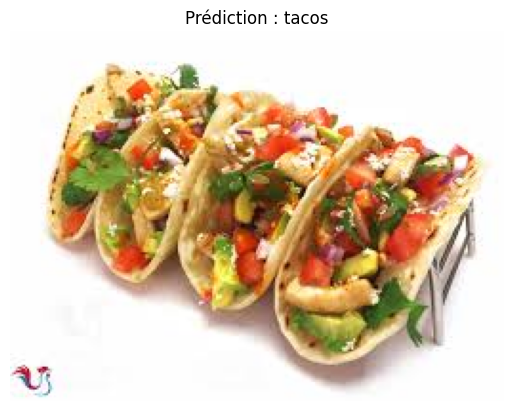

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image_array = img_to_array(image)
    image_array = image_array / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array


test_image_path = "/content/drive/MyDrive/r7.jpg"


test_image = load_and_preprocess_image(test_image_path)

predictions = model.predict(test_image)

predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = target_classes[predicted_class_index]

print(f"Classe prédite : {predicted_class} avec une probabilité de {predictions[0][predicted_class_index]:.2f}")
plt.imshow(load_img(test_image_path))
plt.title(f"Prédiction : {predicted_class}")
plt.axis("off")
plt.show()

In [ ]:
#(architecture + poids)
model_save_path = "/content/drive/MyDrive/effnetb2_full_model.h5"
model.save(model_save_path)
print(f"Modèle complet sauvegardé dans : {model_save_path}")

Modèle complet sauvegardé dans : /content/drive/MyDrive/effnetb2_full_model.h5


Mounted at /content/drive


Modèle chargé depuis : /content/drive/MyDrive/effnetb2_full_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classe prédite : tacos
Scores des classes : [0.12700917 0.72237355 0.1506173 ]


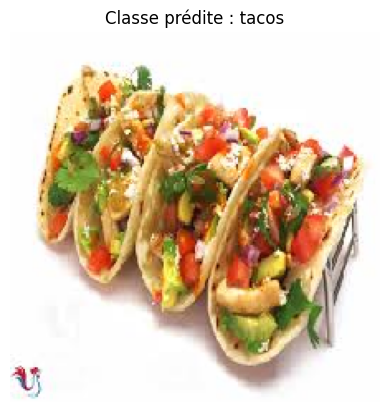

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

target_classes = ['steak', 'tacos', 'pizza']

model_save_path = "/content/drive/MyDrive/effnetb2_full_model.h5"

# Charger le modèle sauvegardé
model = load_model(model_save_path)
print(f"Modèle chargé depuis : {model_save_path}")

# Prétraitement
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def predict_image(image_path, model, target_classes):
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = target_classes[predicted_class_idx]
    return predicted_class, predictions[0]


image_path = "/content/drive/MyDrive/r7.jpg"
if os.path.exists(image_path):
    predicted_class, prediction_scores = predict_image(image_path, model, target_classes)
    print(f"Classe prédite : {predicted_class}")
    print(f"Scores des classes : {prediction_scores}")


    img = load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Classe prédite : {predicted_class}")
    plt.axis('off')
    plt.show()
else:
    print(f"Image non trouvée : {image_path}")

In [ ]:
import tensorflow as tf

# Chemin du modèle sauvegardé (.h5)
model_save_path = "/content/drive/MyDrive/effnetb2_full_model.h5"

# Charger le modèle sauvegardé
model = tf.keras.models.load_model(model_save_path)

# Convertir le modèle en TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Sauvegarder le modèle TFLite
tflite_model_save_path = "/content/drive/MyDrive/effnetb2_model.tflite"
with open(tflite_model_save_path, "wb") as f:
    f.write(tflite_model)

print(f"Modèle TFLite sauvegardé dans : {tflite_model_save_path}")

Saved artifact at '/tmp/tmpxsutyjjh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140247249822016: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140247249823072: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140247249828000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249863248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249863424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249829584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249862896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249828176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249867120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249869408: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [ ]:
# Convertir le modèle en TensorFlow Lite
tflite_model_path = "/content/drive/MyDrive/weight_food/effnetb2_model.tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Modèle TensorFlow Lite sauvegardé dans : {tflite_model_path}")

Saved artifact at '/tmp/tmployy7oy5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140247249822016: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140247249823072: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140247249828000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249863248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249863424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249829584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249862896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249828176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249867120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140247249869408: TensorSpec(shape=(), dtype=tf.resource, name=Non